# Auto-wah project

In [152]:
# Install libraries
! pip install audiolazy 
! pip install pyaudio
! pip install wave
! pip install scipy

  Running setup.py bdist_wheel for wave: started
  Running setup.py bdist_wheel for wave: finished with status 'done'
  Stored in directory: C:\Users\Me\AppData\Local\pip\Cache\wheels\8c\2e\ad\d96151afb1fdccf126346b26eabb91fec3c5ce5cbee7287fbf
Successfully built wave


In [1]:
# Imports
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import IPython
import string
import math

# Audio imports
import scipy.signal as sgn
from scipy.io import wavfile
import audiolazy as al
import pyaudio
import wave
import sys
from audiolazy import sHz, white_noise, line, resonator, AudioIO, Stream

# Helpers
from helpers import *

In [57]:
# Helpers
from helpers import *

# Parameters

Parameters : cuttof freq = milieu entre 500 et 4000
    , res = le 1000 a coté du bw

In [26]:
ma_width = 4000
window = 4000
iir_order = 3

## Import wav file into NumPy array

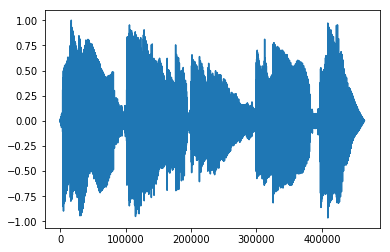

In [3]:
fs, data = wavfile.read('sample.wav') # get data as integers
MAX_VAL = abs(np.iinfo(data.dtype).min) # get max integer
data = data / MAX_VAL # now data is a normalized array of float between -1 and 1
data_length = data.size

plt.plot(data)
IPython.display.Audio(data, rate=fs)

C:\Users\Me\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


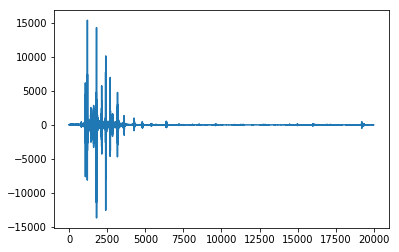

In [71]:
plt.plot(np.fft.fft(data)[:20000])

## Compute the envelope of the signal (and set it to interesting freqs)

<function matplotlib.pyplot.show>

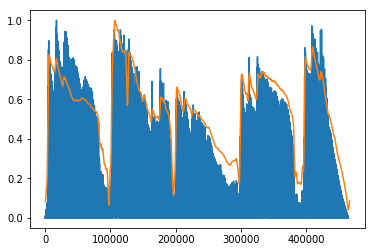

In [9]:
m_hat = abs(sgn.hilbert(data)) # Compute the hilbert transform
envelope = smooth(m_hat, ma_width) # Apply a moving average to smooth out the envelope
envelope /= envelope.max() # Normalize between 0 and 1
envelope **= 0.6 # Re-elevate the envelope
envelope = envelope[ma_width//2:]
plt.plot(abs(data))
plt.plot(envelope)
plt.show

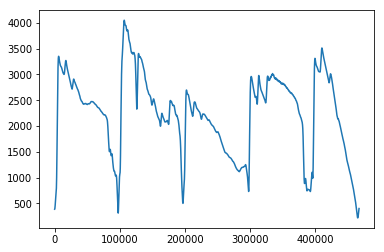

In [10]:
freq_envelope = ( envelope*fs/2 ) /6 + 50
plt.plot(freq_envelope) # Now the envelope is located in "good sounding" freqs for a guitar

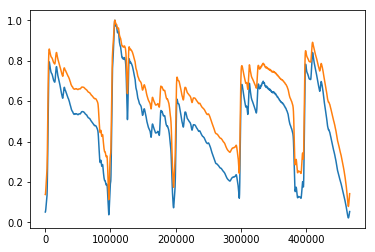

In [35]:
plt.plot(envelope**1.2)
plt.plot(envelope**0.8)
plt.show()

## IIR Filter Method

In [48]:
b, a = sgn.iirfilter(N=2, 
              Wn=[envelope[10000]**1.2, envelope[10000]**0.8],  
              btype='band',
              ftype='butter', 
              analog = False,
              output='ba')
b,a

(array([ 0.01311058,  0.        , -0.02622115,  0.        ,  0.01311058]),
 array([ 1.        ,  2.80195838,  3.62667707,  2.34674425,  0.70342545]))

C:\Users\Me\Anaconda3\lib\site-packages\numpy\core\numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


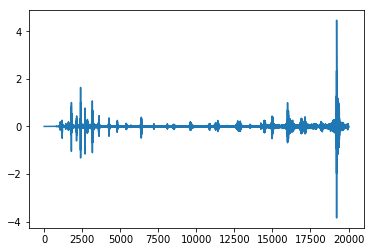

In [74]:
plt.plot(np.fft.fft(iir_butter_filter(data, 0,1, order=2))[0:20000])

In [ ]:
def apply_filter(data, envelope):
    
    b1, a1 = 0,0 # init
    bob = np.zeros(data) 
    
    
    for i in range(data):
        if(i%window == 0):
            b2, a2 = b1, a1
            b1, a1 = sgn.iirfilter(N=iir_order, 
                                  Wn=[envelope[i]**1.1, envelope[i]**0.9],  
                                  btype='band',
                                  ftype='butter', 
                                  output='ba')
        
        bob[i] = data[i] + sum([bob[i-k-1] * b1[k]/a1[k] for k in range(iir_order) ])
            

## STFT method

In [11]:
# STFT of signal

# nperseg = taille d'un chunk
f, t, Zxx = sgn.stft(x=data, fs=fs, nperseg=1024) 
# f = list the freqs des oscilalteurs
# t = list des temps de debut des fenetres.

Zxx = np.swapaxes(Zxx, 1, 0) 
# Zxx = list des chunks, pour chaque chunk, liste des valeurs des fréquences de la DFT.

num_chunks = t.size # ne pas oublier qu'ils s'overlapent a moitié

# Chunk envelopes list: 1 valeur d'enveloppe par chunk
env_repr = np.asarray([envelope[int(t[i]*fs)] for i in range(num_chunks)])

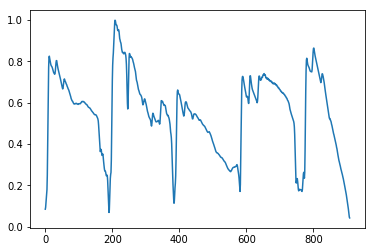

In [14]:
# Le plot des enveloppes representatives est le meme que l'enveloppe normale mais en moins précis
plt.plot(env_repr)

In [12]:
bob = np.zeros((num_chunks, f.size))

# MULTIPLIER LA STFT AVEC UNE LISTE QUI NEST PAS 0 SEULEMENT A L'INCICE CORRESPONDANT A L'ENVELOPPE

for i in range(0, t.size):
    bob[i] = Zxx[i] * 

SyntaxError: invalid syntax (<ipython-input-12-e34022f958df>, line 6)

In [ ]:
plt.plot(bob[2])

## Not working: Moving bandpass filter according to envelope

In [138]:
s, Hz = sHz(fs)

sig = Stream(data) # our raw guitar signal
freq = Stream(freq_envelope) # the envelope as cutoff frequency
bw = (freq)/100

filt = resonator(freq * Hz, bw * Hz) # A simple bandpass filter

bob = filt(sig)
filtered_data = np.asarray(bob.take(data_length))

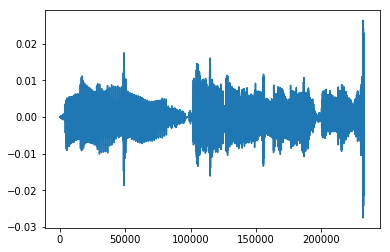

In [140]:
IPython.display.Audio(filtered_data, rate=fs)
plt.plot(filtered_data)